In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
uniref90_aligned_binary_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
uniref90_aligned_multi_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
uniprot_aligned_binary_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
uniprot_aligned_multi_dir_path = os.path.join(os.getcwd(), "..", "..", "..", "..","output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/wiv04/s_mutations.csv")

uniref90_aligned_csv_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/uniref/aligned/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
uniprot_aligned_csv_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..","input/data/coronaviridae/20240313/uniprot/aligned/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")

In [3]:
spike_protein_domain_map = {
    "NTD": [14, 305],
    "S1 Subunit": [14, 685],
    "S2 Subunit": [686, 1273],
    "RBD": [319, 541],
#     "FP": [788, 806],
#     "HR1": [912, 984],
#     "HR2": [1163, 1213]
}

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"

def annotate_region(pos, region):
    pos = int(pos)
    start = spike_protein_domain_map[region][0]
    end = spike_protein_domain_map[region][1]
    if (int(pos) >= start and int(pos) <= end):
        return 1
    else:
        return 0

In [4]:
s_mutations_df = pd.read_csv(s_mutations_file_path)
print(s_mutations_df.shape)
s_mutations_df["perturbation_id"] = s_mutations_df["orig_token"] +  "_" + s_mutations_df["pos"].astype("str") + "_" + s_mutations_df["new_token"]
s_mutations_df.head()

(13, 3)


,orig_token,pos,new_token,perturbation_id
0,D,614,G,D_614_G
1,S,943,P,S_943_P
2,E,484,K,E_484_K
3,N,501,Y,N_501_Y
4,L,452,R,L_452_R


In [5]:
uniref90_df = pd.read_csv(uniref90_aligned_csv_file_path)
print(uniref90_df.shape)
uniprot_df = pd.read_csv(uniprot_aligned_csv_file_path)
print(uniprot_df.shape)

(682, 6)
(3568, 6)


### WIV04 reference sequence

In [6]:
def get_wiv04_position_mapping(df, id):
    wiv04_df = df[df[id] == "WIV04"]
    wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
    
    print(wiv04_aligned_seq)
    
    wiv04_position_mapping = {}
    pos = 0
    for i, token in enumerate(wiv04_aligned_seq):
        if token == "-":
            continue
        else:
            pos += 1
            wiv04_position_mapping[i] = pos
    return wiv04_position_mapping

In [7]:
uniref90_wiv04_position_mapping = get_wiv04_position_mapping(uniref90_df, "uniref90_id")

--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP--------

In [8]:
uniprot_wiv04_position_mapping = get_wiv04_position_mapping(uniprot_df, "uniprot_id")

-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST------

In [9]:
columns = ["id", human_label, "y_true", "orig_token", "perturb_seq_pos", "new_token", pred_diff_col, f"abs_{pred_diff_col}", "perturb_pos", "perturbation_id"]

def get_perturbation_results_df(dir_path, wiv04_position_mapping):
    perturbed_output_dfs = []
    perturbation_output_files = os.listdir(dir_path)
    print(f"Number of files: {len(perturbation_output_files)}")
    # read all the files for each experiment
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(dir_path, perturbation_output_file))
        
        # compute the perturbation difference
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        
        if "WIV04" in perturbation_output_file:
            perturbed_output_dfs.append(df)
    
    perturbed_output_df = pd.concat(perturbed_output_dfs)
    perturbed_output_df.rename(columns={"uniref90_id": "id", "uniprot_id": "id"}, inplace=True)
    
    # compute the perturb_seq_pos
    try:
        perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
        perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")
    except: 
        pass
    
    perturbed_output_df["perturbation_id"] = perturbed_output_df["orig_token"] +  "_" + perturbed_output_df["perturb_seq_pos"].astype("str") + "_" + perturbed_output_df["new_token"]

    return perturbed_output_df[columns]

In [10]:
def get_mutations_df(df):
    mutations_dfs = []
    for _, row in s_mutations_df.iterrows():
        mutation_df = df[df["perturbation_id"] == row["perturbation_id"]]
        mutations_dfs.append(mutation_df)
    return pd.concat(mutations_dfs)

In [11]:
dir_paths = {
    "UniRef90-Aligned-Binary": uniref90_aligned_binary_dir_path,
    "UniRef90-Aligned-Multi": uniref90_aligned_multi_dir_path,
    "UniProt-Aligned-Binary": uniprot_aligned_binary_dir_path,
    "UniProt-Aligned-Multi": uniprot_aligned_multi_dir_path
}

experiment_stats = []
dfs = []
for key, dir_path in dir_paths.items():
    wiv04_position_mapping = None
    print(f"Experiment: {key}")
    if "UniRef90" in key:
        print("UniRef90 WIV04 Mapping")
        wiv04_position_mapping = uniref90_wiv04_position_mapping
    else:
        print("UniProt WIV04 Mapping")
        wiv04_position_mapping = uniprot_wiv04_position_mapping
    
    perturbed_output_df = get_perturbation_results_df(dir_path, wiv04_position_mapping)
    perturbed_output_df["experiment"] = key
    
    mutations_df = get_mutations_df(perturbed_output_df)
    print(f"mutations_df = {mutations_df.shape}")
    
    del perturbed_output_df
    dfs.append(mutations_df)

df = pd.concat(dfs)
print(df.shape)

Experiment: UniRef90-Aligned-Binary
UniRef90 WIV04 Mapping
Number of files: 94
mutations_df = (13, 11)
Experiment: UniRef90-Aligned-Multi
UniRef90 WIV04 Mapping
Number of files: 94
mutations_df = (13, 11)
Experiment: UniProt-Aligned-Binary
UniProt WIV04 Mapping
Number of files: 1019
mutations_df = (13, 11)
Experiment: UniProt-Aligned-Multi
UniProt WIV04 Mapping
Number of files: 1019
mutations_df = (13, 11)
(52, 11)


In [12]:
df.head()

,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,perturbation_id,experiment
17782,WIV04,0.978202,Human,D,614,G,0.000000,0.000000,1595,D_614_G,UniRef90-Aligned-Binary
21476,WIV04,0.978202,Human,S,943,P,0.000000,0.000000,2004,S_943_P,UniRef90-Aligned-Binary
6015,WIV04,0.978306,Human,E,484,K,0.000104,0.000104,1300,E_484_K,UniRef90-Aligned-Binary
27351,WIV04,0.978202,Human,N,501,Y,0.000000,0.000000,1399,N_501_Y,UniRef90-Aligned-Binary
2372,WIV04,0.978061,Human,L,452,R,-0.000141,0.000141,1243,L_452_R,UniRef90-Aligned-Binary


In [13]:
df[["experiment","perturbation_id"]].value_counts()

experiment               perturbation_id
UniProt-Aligned-Binary   D_614_G            1
                         E_484_K            1
UniRef90-Aligned-Binary  E_484_Q            1
                         K_417_N            1
                         K_417_T            1
                         L_452_R            1
                         N_501_Y            1
                         P_681_H            1
                         Q_677_H            1
                         Q_677_P            1
                         S_477_G            1
                         S_477_N            1
                         S_943_P            1
UniRef90-Aligned-Multi   D_614_G            1
                         E_484_K            1
                         E_484_Q            1
                         K_417_N            1
                         K_417_T            1
                         L_452_R            1
                         N_501_Y            1
                         P_681_H       

In [14]:
df[df["perturbation_id"] == "D_839_Y"]

,id,Human,y_true,orig_token,perturb_seq_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_pos,perturbation_id,experiment


In [15]:
plt.clf()
plt.figure(figsize=(18, 12))
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 14})
# sns.swarmplot(data=df, x=pred_diff_col, y="perturbation_id",size=1, palette="dark:k", hue="experiment", ax=g.ax)


<Figure size 432x288 with 0 Axes>

<Figure size 1296x864 with 0 Axes>

/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


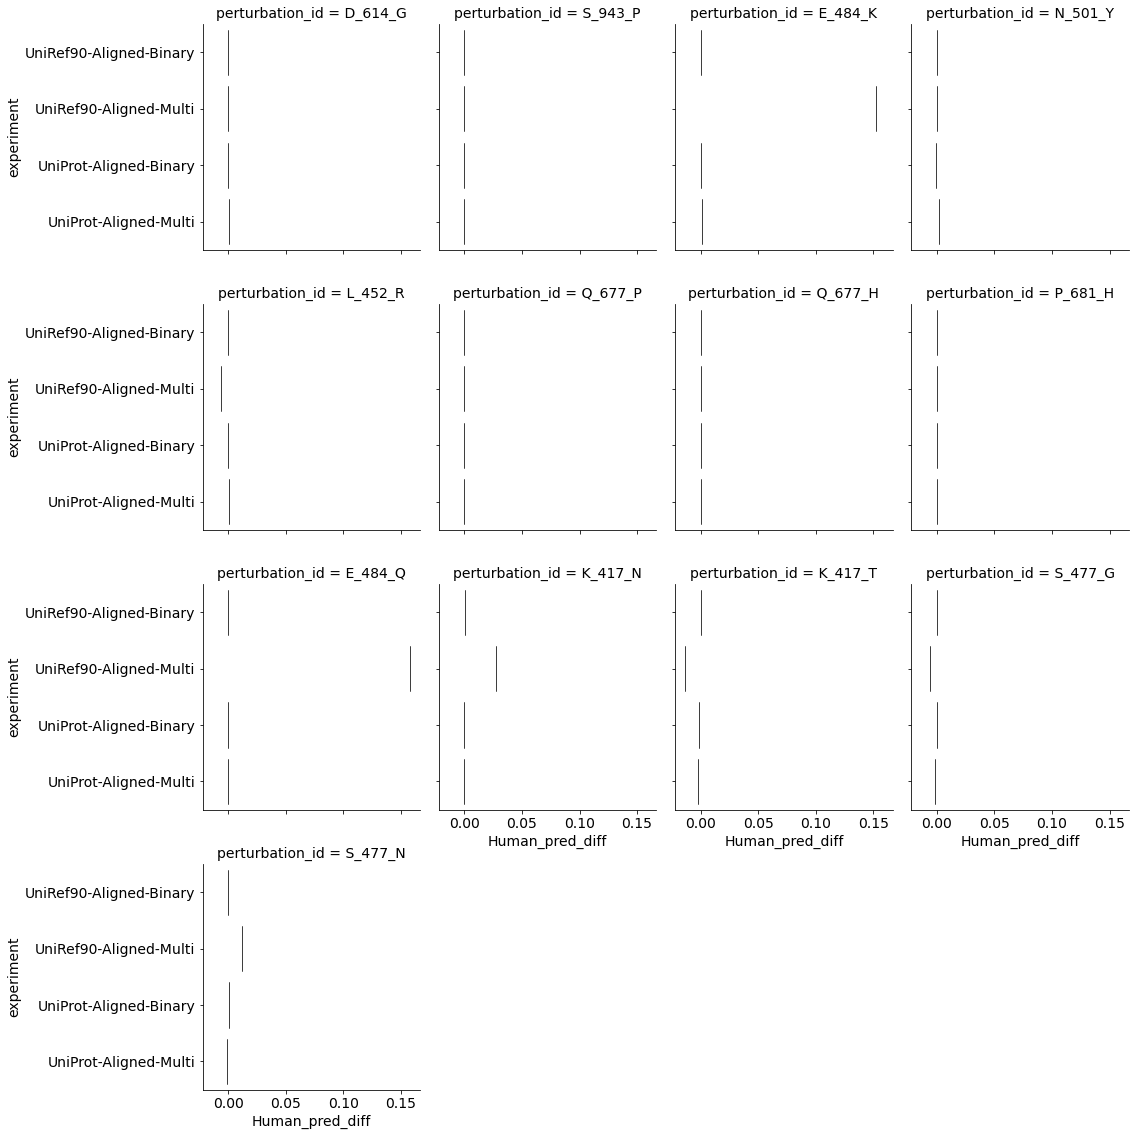

In [16]:
g = sns.FacetGrid(data=df, col="perturbation_id", col_wrap=4, height=4, sharex=True, sharey=True)
g.map(sns.boxplot, pred_diff_col, "experiment")